# Goals for This Notebook
At this stage we will group or clustering street in Bandung City based on data length, time spent, and speed for irregularities in traffic. The clustering algorithm that I chose is K-Means.
- [Import Python Packages]()
- [Import Dataset]()
- [Data Transformation]()
- [K-Means Model]()
- [Elbow Method]()
- [Silhoutte Score]()
- [Fitting K-Means Model with K=4 to Dataset]()
- [Clusters Visualization]()
- [Clustering by Irregularities Length]()
- [Clustering by Average Irregularities Time Spent]()
- [Clustering by Average Irregularities Speed]()
- [Cluster Members]()

![](https://editor.analyticsvidhya.com/uploads/56854k%20means%20clustering.png)

# Import Python Packages

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
import pickle

import warnings

warnings.filterwarnings("ignore")


# Import Dataset

In [2]:
df = pd.read_csv(
    "../../data/processed-data/Data Traffic Waze Kota Bandung.zip", compression="zip"
)


# Data Transformation
At this stage we will transform data so that the data we will conduct training on the Machine Learning algorithm can be optimized and relevant.

## Remove Outliers

In [3]:
numerical_columns = [
    "Jam Length (meters)",
    "Jam Time Spent (seconds)",
    "Jam Speed (Km/h)",
    "Total Jam Records",
    "Irregularities Length (meters)",
    "Irregularities Time Spent (seconds)",
    "Irregularities Speed (Km/h)",
    "Total Irregularities Records",
    "Total Alert Records",
]

print(f"Jumlah baris sebelum memfilter outlier: {len(df)}")

filtered_entries = np.array([True] * len(df))
for col in df[numerical_columns].columns.tolist():
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    filtered_entries = (
        (df[col] >= low_limit) & (df[col] <= high_limit)
    ) & filtered_entries

df = df[filtered_entries]

print(f"Jumlah baris setelah memfilter outlier: {len(df)}")


Jumlah baris sebelum memfilter outlier: 19801
Jumlah baris setelah memfilter outlier: 14752


## Choosing The Relevant Columns

In [4]:
# we choose these columns because they have moderate correlations (analysis in Data Description notebook)
filtered_df = df[
    [
        "Street",
        "Irregularities Length (meters)",
        "Irregularities Time Spent (seconds)",
        "Irregularities Speed (Km/h)",
    ]
]
# we groupby by the median because the data distribution is skewed (analysis in Data Description notebook)
filtered_df = filtered_df.groupby(["Street"]).median()


## Feature Scaling

In [5]:
minMaxScaler = MinMaxScaler()
normalized_df = filtered_df.copy()
normalized_df[normalized_df.columns.tolist()] = minMaxScaler.fit_transform(
    normalized_df[normalized_df.columns.tolist()]
)


# K-Means Model
K-means clustering is a type of unsupervised learning, which is used with unlabeled dataset. The goal of this algorithm is to find K groups in the data. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity.

In [6]:
# selecting features
X = normalized_df.loc[:, :].values

# instatiate the clustering model and visualizer
cluster_model = KMeans(random_state=42)


# Elbow Method
Elbow method is a commonly used technique to determine the optimal number of clusters in K-Means clustering. The basic idea of the elbow method is to plot the number of clusters against the corresponding variation (or sum of squared distances) between data points and their assigned cluster centroids. The optimal number of clusters is where the "elbow" of the curve is located in the plot.

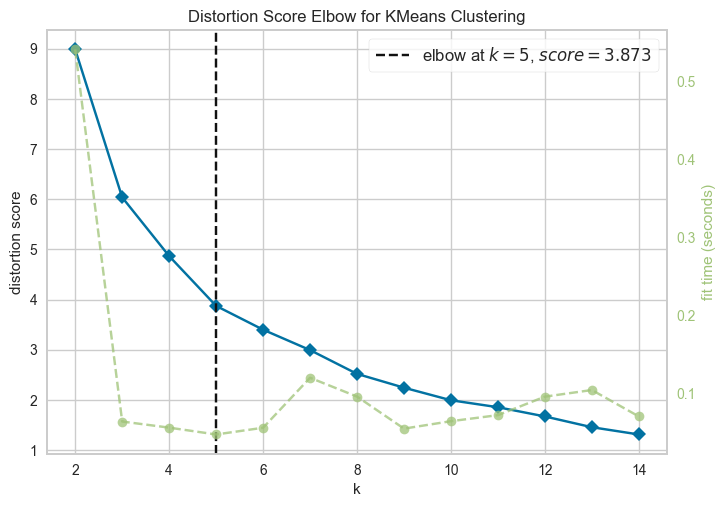

In [7]:
visualizer = KElbowVisualizer(cluster_model, k=(2, 15))
visualizer.fit(X)  # fit the data to the visualizer
visualizer.show()  # finalize and render the figure
plt.show()


The above graph selects an Elbow point at K=5. Let’s validate the value of K using the Silhouette plot.

# Silhouette Score
Silhouette score is a widely used metric for evaluating the quality of clusters in K-Means clustering. The Silhouette score measures how well each data point fits into its assigned cluster, by calculating the mean distance between the data point and all other points in its own cluster, as well as the mean distance between the data point and all other points in the nearest neighboring cluster. The Silhouette score ranges from -1 to 1, where a score of 1 indicates a good clustering, and a score of -1 indicates a poor clustering.

,n_clusters,average_scores
0,2,0.506845
1,3,0.403974
2,4,0.391234
3,5,0.382560
4,8,0.356966
5,10,0.348226
6,9,0.344923
7,7,0.343975
8,6,0.336116


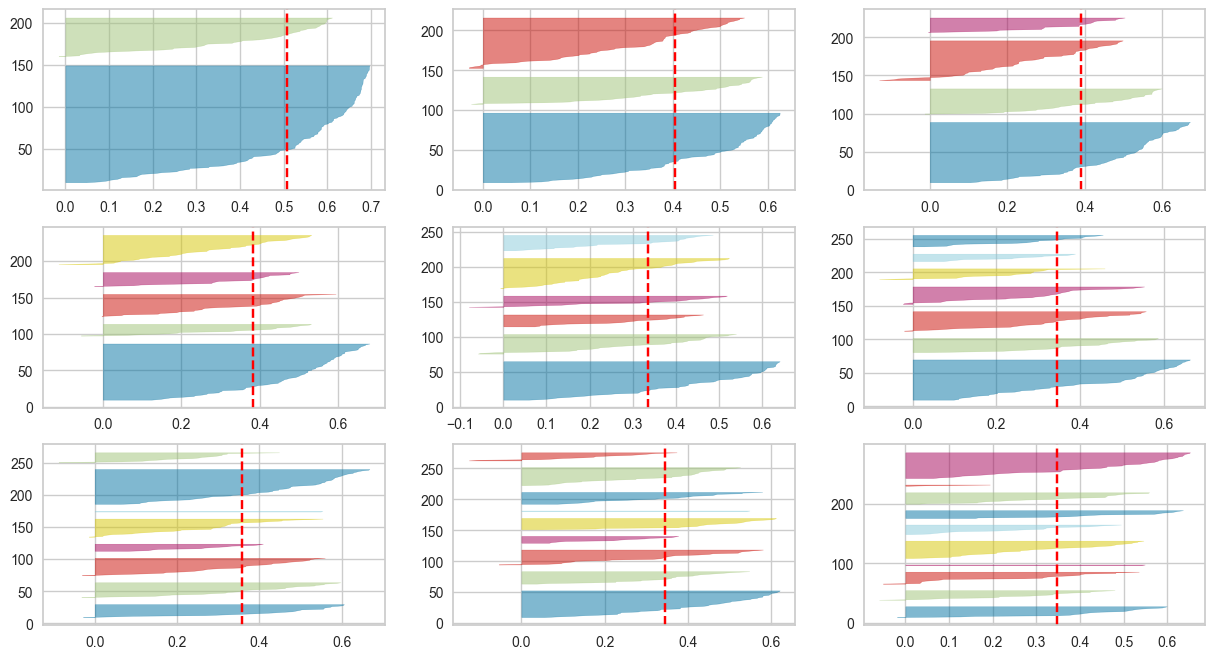

In [8]:
k_range = list(range(2, 11))
lst_scores = []

fig, axs = plt.subplots(3, 3, figsize=(15, 8))
for k, ax_i in zip(
    k_range, [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]
):
    """
    Create KMeans instances for different number of clusters
    """
    cluster_model = KMeans(n_clusters=k, random_state=42)
    """
    Print the Silhoutte Score
    """
    preds = cluster_model.fit_predict(X)
    score = silhouette_score(X, preds)
    lst_scores.append(score)
    """
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    """
    q = ax_i[0]
    mod = ax_i[1]
    visualizer = SilhouetteVisualizer(
        cluster_model, colors="yellowbrick", ax=axs[q][mod]
    )
    visualizer.fit(X)

df_sillhoutte = pd.DataFrame(
    list(zip(k_range, lst_scores)), columns=["n_clusters", "average_scores"]
)
df_sillhoutte.sort_values("average_scores", inplace=True, ascending=False)
df_sillhoutte.reset_index(drop=True)


The Silhouette score is maximum(0.50) for K = 2 but that’s not sufficient to select the optimal K. The following conditions should be checked to pick the right ‘K’ using the Silhouette plots:
- For a particular K, all the clusters should have a Silhouette score more than the average score of the dataset (represented by a red dotted line). The x-axis represents the Silhouette score.
- There should not be wide fluctuations in the size of the clusters. The width of the clusters represents the number of data points

The value of 4 for n_clusters looks to be optimal one. The silhouette score for each cluster is above average silhouette scores. Also, the thickness is more uniform than the plot with n_cluster as 2 or 3 with one cluster thickness much more than the other. **Thus, one can select the optimal number of clusters as 4**.

# Fitting K-Means with K=4 to Features


In [18]:
cluster_model = KMeans(n_clusters=4, random_state=42)
preds = cluster_model.fit_predict(X)
filtered_df["K-Means"] = preds

# save the model
pickle.dump(preds, open('../../models/clustering_kmeans.pkl', 'wb'))

# Clusters Visualization

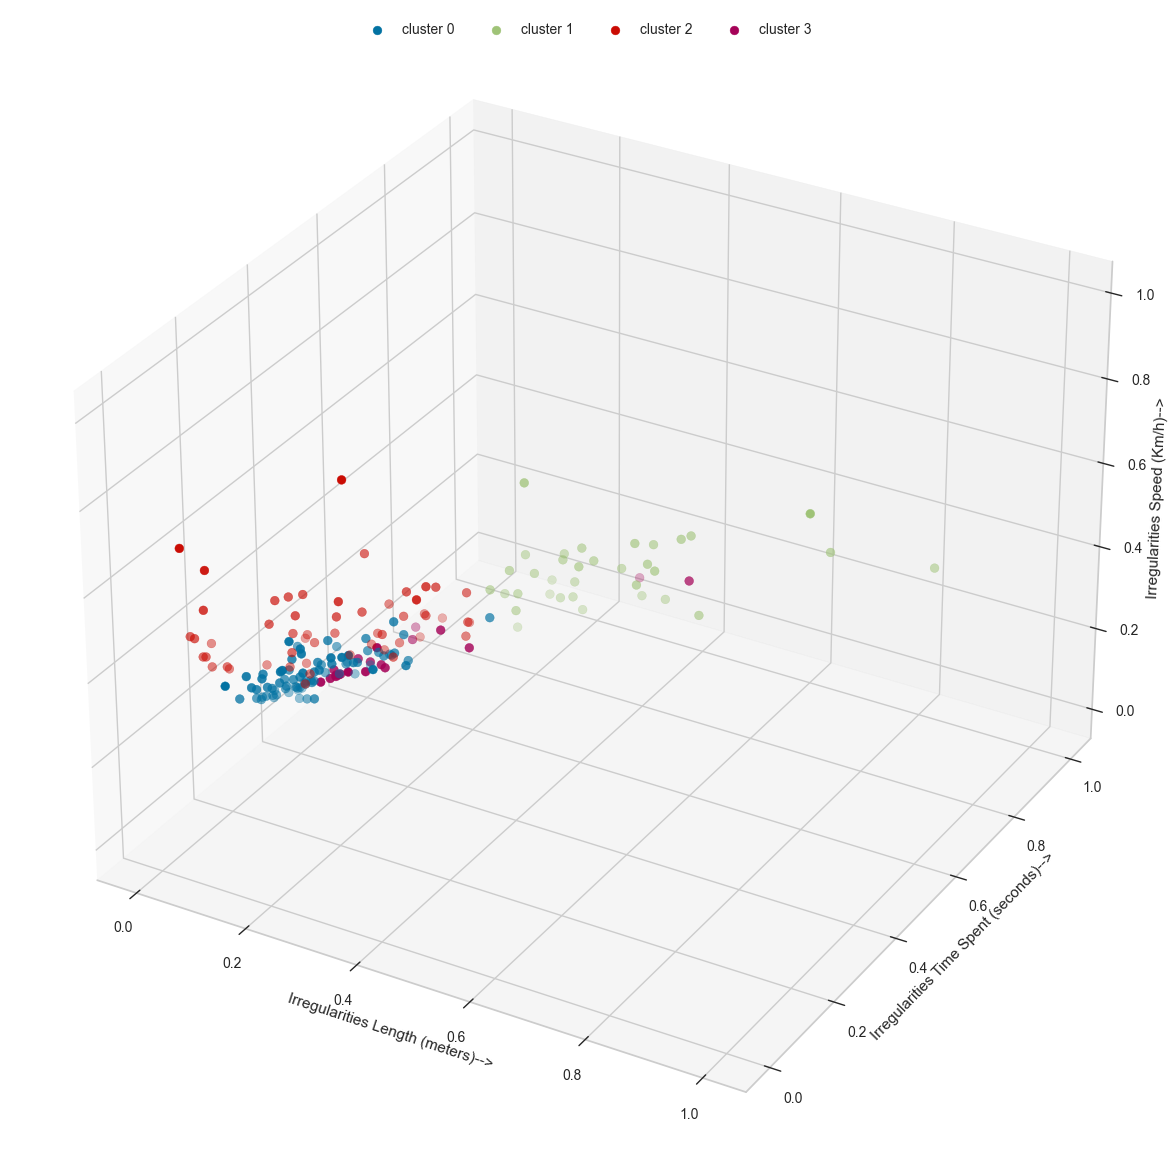

In [10]:
# 3d scatterplot using matplotlib
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    X[preds == 0, 0],
    X[preds == 0, 1],
    X[preds == 0, 2],
    s=40,
    label="cluster 0",
)
ax.scatter(
    X[preds == 1, 0],
    X[preds == 1, 1],
    X[preds == 1, 2],
    s=40,
    label="cluster 1",
)
ax.scatter(
    X[preds == 2, 0],
    X[preds == 2, 1],
    X[preds == 2, 2],
    s=40,
    label="cluster 2",
)
ax.scatter(
    X[preds == 3, 0],
    X[preds == 3, 1],
    X[preds == 3, 2],
    s=40,
    label="cluster 3",
)
ax.set_xlabel("Irregularities Length (meters)-->")
ax.set_ylabel("Irregularities Time Spent (seconds)-->")
ax.set_zlabel("Irregularities Speed (Km/h)-->")
ax.legend(ncol=5, loc="upper center")
plt.show()


In [11]:
# analysis each cluster's characteristics
lst_clusters = [0, 1, 2, 3]
lst_total_members = []
lst_avg_irreg_length = []
lst_avg_irreg_time = []
lst_avg_irreg_speed = []

for cluster in lst_clusters:
    lst_total_members.append(filtered_df[filtered_df["K-Means"] == cluster].shape[0])
    lst_avg_irreg_length.append(
        round(
            filtered_df[filtered_df["K-Means"] == cluster][
                "Irregularities Length (meters)"
            ].median(),
            2,
        )
    )
    lst_avg_irreg_time.append(
        round(
            filtered_df[filtered_df["K-Means"] == cluster][
                "Irregularities Time Spent (seconds)"
            ].median(),
            2,
        )
    )
    lst_avg_irreg_speed.append(
        round(
            filtered_df[filtered_df["K-Means"] == cluster][
                "Irregularities Speed (Km/h)"
            ].median(),
            2,
        )
    )

df_clusters = pd.DataFrame(
    list(
        zip(
            lst_clusters,
            lst_total_members,
            lst_avg_irreg_length,
            lst_avg_irreg_time,
            lst_avg_irreg_speed,
        )
    ),
    columns=[
        "Cluster",
        "Total Member",
        "Average Irregularities Length (meters)",
        "Average Irregularities Time Spent (seconds)",
        "Average Irregularities Speed (Km/h)",
    ],
)

df_clusters.sort_values(
    [
        "Average Irregularities Length (meters)",
        "Average Irregularities Time Spent (seconds)",
        "Average Irregularities Speed (Km/h)",
    ],
    ascending=False,
).reset_index(drop=True)


,Cluster,Total Member,Average Irregularities Length (meters),Average Irregularities Time Spent (seconds),Average Irregularities Speed (Km/h)
0,1,34,1523.75,752.50,7.62
1,2,53,856.00,513.00,5.92
2,0,80,644.00,644.00,3.82
3,3,20,583.50,878.25,2.39


# Clustering by Average Irregularities Length (meters)

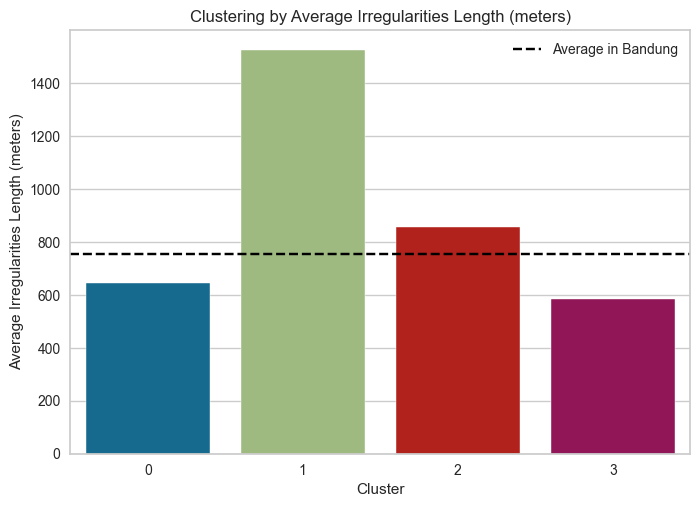

In [12]:
sns.set_style("whitegrid")
sns.barplot(data=df_clusters, x="Cluster", y="Average Irregularities Length (meters)")

plt.axhline(
    y=filtered_df["Irregularities Length (meters)"].median(),
    color="black",
    linestyle="dashed",
    label="Average in Bandung",
)

plt.legend(loc="best")
plt.title("Clustering by Average Irregularities Length (meters)")
plt.show()


# Clustering by Average Irregularities Time Spent (seconds)

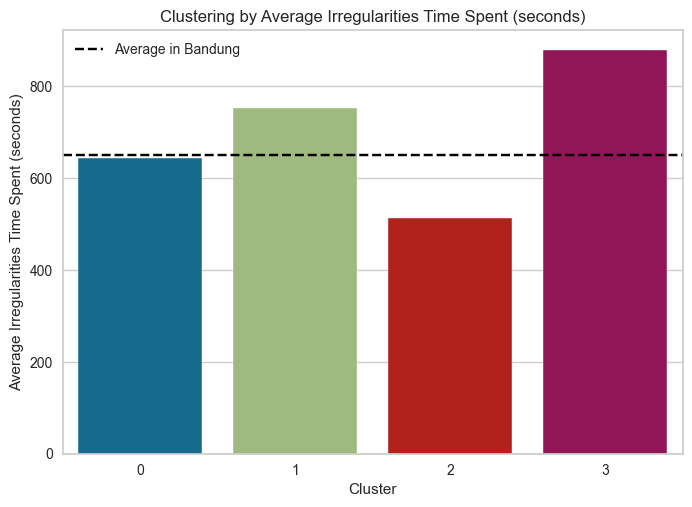

In [13]:
sns.barplot(
    data=df_clusters, x="Cluster", y="Average Irregularities Time Spent (seconds)"
)

plt.axhline(
    y=filtered_df["Irregularities Time Spent (seconds)"].median(),
    color="black",
    linestyle="dashed",
    label="Average in Bandung",
)

plt.legend(loc="best")
plt.title("Clustering by Average Irregularities Time Spent (seconds)")
plt.show()


# Clustering by Average Irregularities Speed (Km/h)

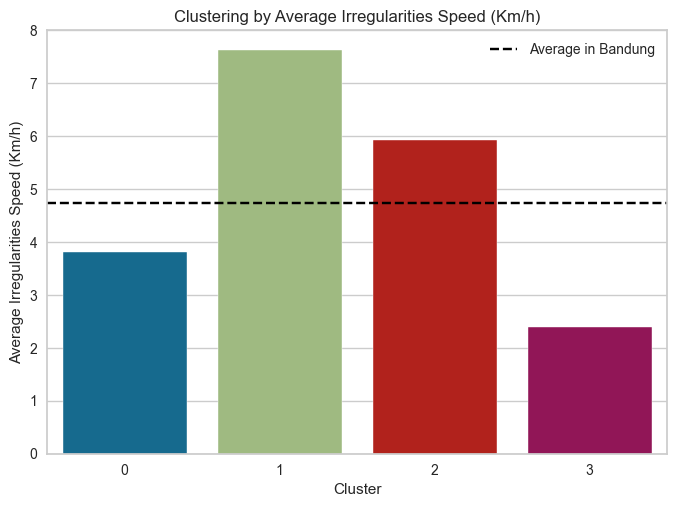

In [14]:
sns.barplot(data=df_clusters, x="Cluster", y="Average Irregularities Speed (Km/h)")

plt.axhline(
    y=filtered_df["Irregularities Speed (Km/h)"].median(),
    color="black",
    linestyle="dashed",
    label="Average in Bandung",
)

plt.legend(loc="best")
plt.title("Clustering by Average Irregularities Speed (Km/h)")
plt.show()


# Cluster's Members

In [15]:
df_cluster_members = filtered_df.copy()
df_cluster_members.sort_values('K-Means', inplace=True)
df_cluster_members.reset_index(inplace=True, drop=False)
df_cluster_members = df_cluster_members[['Street', 'K-Means']]
df_cluster_members.to_csv('../../data/interim-data/cluster_member.csv', index=False)
df_cluster_members.set_index('Street', inplace=True)
df_cluster_members.style.background_gradient(cmap='YlGnBu', low=0, high=3)

,K-Means
Street,
Sersan Bajuri,0
Guntursari Wetan,0
Karawitan,0
Golf Barat,0
Gerbang Tol Pasir Koja,0
Kawaluyaan,0
Soekarno-Hatta,0
Gempol Sari,0
Pahlawan,0
